# Build a Text2SQL ReAct Agentic AI System with LangChain

### Building a Text2SQL ReAct Agentic AI System

In this project, we will design a **Text2SQL ReAct Agentic AI System** to enhance the interaction with databases using natural language queries. This workflow will leverage the `create_react_agent` function from **LangGraph**, which offers a more robust implementation compared to the deprecated LangChain version. The workflow consists of the following components:

1. **Agent System Prompt**: The agent is designed to interpret user questions and generate syntactically correct SQL queries. Key rules include:
   - Limiting results to at most 10 unless specified by the user.
   - Querying only relevant columns instead of retrieving all columns from a table.
   - Ensuring plain text SQL query generation without additional formatting or code blocks.

2. **SQL Database Tools**: The system uses tools to interact with the database schema and validate queries:
   - **DB_QUERY**: Executes the generated SQL query.
   - **DB_SCHEMA**: Fetches the schema details of the database.
   - **DB_LIST_TABLES**: Lists all tables in the database.
   - **DB_QUERY_CHECKER**: Validates the correctness of the SQL query before execution.

3. **SQL Database Engine**: Executes the validated SQL queries and retrieves the required data from the database.

4. **ReAct Reasoning Framework**: The agent combines reasoning with actions to ensure accurate query formulation and execution.

5. **Final Response**: The results are processed and returned to the user in a human-friendly format.

By using LangGraph's `create_react_agent`, this system ensures a more reliable, efficient, and user-friendly interaction with SQL databases, making it easier to extract meaningful insights from structured data.

![](https://i.imgur.com/4PNKql9.png)

## Install OpenAI, and LangChain dependencies

In [1]:
# !pip install langchain==0.3.14
# !pip install langchain-openai==0.3.0
# !pip install langchain-community==0.3.14
# !pip install langgraph==0.2.66

In [2]:
# !apt-get install sqlite3 -y

## Enter Open AI API Key

In [3]:
# from getpass import getpass

# OPENAI_KEY = getpass('Enter Open AI API Key: ')

## Setup Environment Variables

In [4]:
# import os

# os.environ['OPENAI_API_KEY'] = OPENAI_KEY

In [ ]:
# ============================================================================
# ENVIRONMENT SETUP
# ============================================================================
# We use python-dotenv to securely load API keys from a .env file
# This is a best practice to avoid hardcoding sensitive credentials in code
# 
# Your .env file should contain: OPENAI_API_KEY=your_api_key_here
# ============================================================================

from dotenv import load_dotenv, find_dotenv

# find_dotenv() searches for .env file in current and parent directories
# load_dotenv() loads the environment variables from the found .env file
load_dotenv(find_dotenv())

True

## Get SQL DB Script

In [6]:
# # in case of issues download from https://drive.google.com/file/d/16mZm3C7xKpPqp_86e64uzduLpM5mPUdq/view?usp=sharing and upload
# !gdown 16mZm3C7xKpPqp_86e64uzduLpM5mPUdq

## Create Comic Store Database

In [ ]:
# ============================================================================
# VERIFY SQLITE INSTALLATION
# ============================================================================
# SQLite is a lightweight, file-based database perfect for learning and prototyping.
# It comes pre-installed on most systems (macOS, Linux) or with Python.
# ============================================================================

!sqlite3 --version

3.43.2 2023-10-10 13:08:14 1b37c146ee9ebb7acd0160c0ab1fd11017a419fa8a3187386ed8cb32b709aapl (64-bit)


In [ ]:
# ============================================================================
# CREATE THE DATABASE FROM SQL SCRIPT
# ============================================================================
# This command reads the SQL script and creates all tables with sample data.
# The script creates: Branch, Publisher, Comic, Customer, Employee, 
# Inventory, Sale, and SaleTransactions tables.
# ============================================================================

!sqlite3 ComicStore.db ".read ./comicdb_create_script.sql"
print("✅ Database created successfully!")

In [ ]:
# ============================================================================
# VERIFY TABLES WERE CREATED
# ============================================================================
# Query the SQLite system table to list all user-created tables.
# sqlite_master is a special table that stores the database schema.
# ============================================================================

print("Tables in the database:")
!sqlite3 ComicStore.db "SELECT name FROM sqlite_master WHERE type='table';"

Branch
Employee
Publisher
Comic
Inventory
Customer
Sale
SaleTransactions


In [ ]:
%%bash
# ============================================================================
# PREVIEW THE COMIC TABLE (Native SQLite Query)
# ============================================================================
# This uses bash magic (%%bash) to run SQLite commands directly.
# The .headers on and .mode column options format the output nicely.
# ============================================================================

sqlite3 ComicStore.db <<EOF
.headers on
.mode column
SELECT * FROM Comic LIMIT 10;
EOF

ComicId  Title                            PublisherId  Genre            Price  ReleaseDate
-------  -------------------------------  -----------  ---------------  -----  -----------
1        Spider-Man: Homecoming           1            Superhero        19.99  2017-07-07 
2        Batman: Year One                 2            Superhero        14.99  1987-02-01 
3        Hellboy: Seed of Destruction     3            Supernatural     24.99  1994-10-01 
4        Saga Volume 1                    4            Fantasy          12.99  2012-03-14 
5        Transformers: All Hail Megatron  5            Science Fiction  25.99  2008-09-01 
6        X-Men: Days of Future Past       1            Superhero        18.99  1981-01-01 
7        The Killing Joke                 2            Superhero        14.99  1988-03-29 
8        Sin City: The Hard Goodbye       4            Noir             22.99  1991-06-01 
9        Usagi Yojimbo Volume 1           5            Adventure        20.99  1987-09-01 

In [ ]:
# ============================================================================
# CONNECT TO THE DATABASE USING LANGCHAIN'S SQLDatabase UTILITY
# ============================================================================
# SQLDatabase is a wrapper that provides convenient methods for:
# - Running SQL queries
# - Getting table schemas
# - Listing available tables
# This wrapper will be used by our SQL tools to interact with the database
# ============================================================================

from langchain_community.utilities import SQLDatabase

# Create a connection to our SQLite database
# The URI format for SQLite is: sqlite:///path/to/database.db
db = SQLDatabase.from_uri("sqlite:///ComicStore.db")

# Verify the connection and print database info
print(f"Database Dialect: {db.dialect}")
print(f"Available Tables: {db.get_usable_table_names()}")

In [ ]:
# ============================================================================
# NOTE: The cell above already prints the dialect and table names.
# This cell is kept for reference - you can uncomment to run separately.
# ============================================================================

# print(db.dialect)
# print(db.get_usable_table_names())

sqlite
['Branch', 'Comic', 'Customer', 'Employee', 'Inventory', 'Publisher', 'Sale', 'SaleTransactions']


## Explore the Database Schema and Sample Data

## Overview of the Comic Store Database

In this project, we will utilize a **Comic Store Database** to demonstrate the capabilities of a Text2SQL workflow. The database schema includes the following entities and relationships:

1. **Branch**: Stores details about comic store branches, including their location and contact information.

2. **Publisher**: Contains information about publishers, such as their name, country, and the year they were established.

3. **Comic**: Represents the comics, including their title, genre, price, release date, and associated publisher.

4. **Customer**: Tracks customer details, including their contact information and location.

5. **Employee**: Holds data about store employees, including their branch, title, and hire date.

6. **Inventory**: Manages the stock of comics available at different branches.

7. **Sale**: Records sales transactions, including the employee and customer involved, as well as the total amount and sale date.

8. **SaleTransactions**: Tracks individual items within a sale, including the quantity and price of each comic sold.

### Relationships:
- A **Publisher** publishes multiple **Comics**.
- A **Branch** stocks multiple **Comics** through the **Inventory** table.
- A **Customer** makes **Sales**, which are processed by **Employees**.
- Each **Sale** contains multiple items recorded in **SaleTransactions**.

This database schema is well-suited for queries related to inventory management, sales analysis, customer interactions, and employee performance in the context of a comic store business.


![](https://i.imgur.com/YzNCLpV.png)

In [ ]:
# ============================================================================
# EXPLORE SAMPLE DATA FROM KEY TABLES
# ============================================================================
# The db.run() method executes SQL queries and returns results
# Setting include_columns=True returns data as a list of dictionaries
# with column names as keys for better readability
# ============================================================================

# View sample data from the Comic table - our main product catalog
print("=" * 60)
print("COMIC TABLE - Sample Data (Product Catalog)")
print("=" * 60)
print(db.run("SELECT * FROM Comic LIMIT 5;", include_columns=True))

# View sample data from the Employee table
print("\n" + "=" * 60)
print("EMPLOYEE TABLE - Sample Data (Staff Information)")
print("=" * 60)
print(db.run("SELECT * FROM Employee LIMIT 5;", include_columns=True))

# View sample data from the Sale table
print("\n" + "=" * 60)
print("SALE TABLE - Sample Data (Transaction Records)")
print("=" * 60)
print(db.run("SELECT * FROM Sale LIMIT 5;", include_columns=True))

# View sample data from the SaleTransactions table
print("\n" + "=" * 60)
print("SALE TRANSACTIONS TABLE - Sample Data (Individual Items in Sales)")
print("=" * 60)
print(db.run("SELECT * FROM SaleTransactions LIMIT 5;", include_columns=True))

"[{'ComicId': 1, 'Title': 'Spider-Man: Homecoming', 'PublisherId': 1, 'Genre': 'Superhero', 'Price': 19.99, 'ReleaseDate': '2017-07-07'}, {'ComicId': 2, 'Title': 'Batman: Year One', 'PublisherId': 2, 'Genre': 'Superhero', 'Price': 14.99, 'ReleaseDate': '1987-02-01'}, {'ComicId': 3, 'Title': 'Hellboy: Seed of Destruction', 'PublisherId': 3, 'Genre': 'Supernatural', 'Price': 24.99, 'ReleaseDate': '1994-10-01'}, {'ComicId': 4, 'Title': 'Saga Volume 1', 'PublisherId': 4, 'Genre': 'Fantasy', 'Price': 12.99, 'ReleaseDate': '2012-03-14'}, {'ComicId': 5, 'Title': 'Transformers: All Hail Megatron', 'PublisherId': 5, 'Genre': 'Science Fiction', 'Price': 25.99, 'ReleaseDate': '2008-09-01'}, {'ComicId': 6, 'Title': 'X-Men: Days of Future Past', 'PublisherId': 1, 'Genre': 'Superhero', 'Price': 18.99, 'ReleaseDate': '1981-01-01'}, {'ComicId': 7, 'Title': 'The Killing Joke', 'PublisherId': 2, 'Genre': 'Superhero', 'Price': 14.99, 'ReleaseDate': '1988-03-29'}, {'ComicId': 8, 'Title': 'Sin City: The Ha

In [ ]:
# ============================================================================
# NOTE: The above cell already displays data from all key tables.
# These individual cells are commented out to avoid redundancy.
# Uncomment if you want to explore tables separately.
# ============================================================================

# db.run("SELECT * FROM Employee LIMIT 10;", include_columns=True)

"[{'EmployeeId': 1, 'FirstName': 'John', 'LastName': 'Doe', 'Title': 'Manager', 'BranchId': 1, 'HireDate': '2015-06-01', 'Email': 'john.doe@comicstore.com', 'Phone': '555-1234'}, {'EmployeeId': 2, 'FirstName': 'Jane', 'LastName': 'Smith', 'Title': 'Sales Associate', 'BranchId': 1, 'HireDate': '2017-09-15', 'Email': 'jane.smith@comicstore.com', 'Phone': '555-5678'}, {'EmployeeId': 3, 'FirstName': 'Alice', 'LastName': 'Brown', 'Title': 'Sales Associate', 'BranchId': 2, 'HireDate': '2018-03-12', 'Email': 'alice.brown@comicstore.com', 'Phone': '555-9876'}, {'EmployeeId': 4, 'FirstName': 'Michael', 'LastName': 'Clark', 'Title': 'Manager', 'BranchId': 2, 'HireDate': '2016-02-20', 'Email': 'michael.clark@comicstore.com', 'Phone': '555-6543'}, {'EmployeeId': 5, 'FirstName': 'Emily', 'LastName': 'White', 'Title': 'Sales Associate', 'BranchId': 3, 'HireDate': '2019-07-10', 'Email': 'emily.white@comicstore.com', 'Phone': '555-4321'}]"

In [ ]:
# db.run("SELECT * FROM Sale LIMIT 10;", include_columns=True)

"[{'SaleId': 1, 'CustomerId': 1, 'EmployeeId': 1, 'SaleDate': '2023-01-15', 'TotalAmount': 54.97}, {'SaleId': 2, 'CustomerId': 2, 'EmployeeId': 2, 'SaleDate': '2023-01-20', 'TotalAmount': 49.97}, {'SaleId': 3, 'CustomerId': 3, 'EmployeeId': 3, 'SaleDate': '2023-01-25', 'TotalAmount': 59.97}, {'SaleId': 4, 'CustomerId': 4, 'EmployeeId': 4, 'SaleDate': '2023-01-30', 'TotalAmount': 45.98}, {'SaleId': 5, 'CustomerId': 5, 'EmployeeId': 5, 'SaleDate': '2023-02-05', 'TotalAmount': 29.97}, {'SaleId': 6, 'CustomerId': 6, 'EmployeeId': 1, 'SaleDate': '2023-02-10', 'TotalAmount': 74.97}, {'SaleId': 7, 'CustomerId': 7, 'EmployeeId': 2, 'SaleDate': '2023-02-15', 'TotalAmount': 64.97}, {'SaleId': 8, 'CustomerId': 8, 'EmployeeId': 3, 'SaleDate': '2023-02-20', 'TotalAmount': 49.99}, {'SaleId': 9, 'CustomerId': 9, 'EmployeeId': 4, 'SaleDate': '2023-02-25', 'TotalAmount': 49.97}, {'SaleId': 10, 'CustomerId': 10, 'EmployeeId': 5, 'SaleDate': '2023-03-01', 'TotalAmount': 65.98}]"

In [ ]:
# db.run("SELECT * FROM SaleTransactions LIMIT 10;", include_columns=True)

"[{'TransactionId': 1, 'SaleId': 1, 'ComicId': 1, 'Quantity': 1, 'Price': 19.99}, {'TransactionId': 2, 'SaleId': 1, 'ComicId': 2, 'Quantity': 2, 'Price': 14.99}, {'TransactionId': 3, 'SaleId': 2, 'ComicId': 3, 'Quantity': 1, 'Price': 24.99}, {'TransactionId': 4, 'SaleId': 2, 'ComicId': 4, 'Quantity': 1, 'Price': 24.98}, {'TransactionId': 5, 'SaleId': 3, 'ComicId': 5, 'Quantity': 2, 'Price': 29.99}, {'TransactionId': 6, 'SaleId': 3, 'ComicId': 6, 'Quantity': 1, 'Price': 29.98}, {'TransactionId': 7, 'SaleId': 4, 'ComicId': 7, 'Quantity': 2, 'Price': 22.99}, {'TransactionId': 8, 'SaleId': 4, 'ComicId': 8, 'Quantity': 1, 'Price': 22.99}, {'TransactionId': 9, 'SaleId': 5, 'ComicId': 9, 'Quantity': 2, 'Price': 14.99}, {'TransactionId': 10, 'SaleId': 6, 'ComicId': 10, 'Quantity': 2, 'Price': 29.99}]"

In [ ]:
# ============================================================================
# VIEW DETAILED TABLE SCHEMA INFORMATION
# ============================================================================
# get_table_info() returns:
# 1. The CREATE TABLE statement showing column names, types, and constraints
# 2. Sample rows from the table to understand the data format
# 3. Foreign key relationships between tables
# 
# This is exactly what our SQL agent will use to understand the database!
# ============================================================================

print("DETAILED SCHEMA FOR KEY TABLES:")
print(db.get_table_info(table_names=['Comic', 'Sale']))


CREATE TABLE "Comic" (
	"ComicId" INTEGER NOT NULL, 
	"Title" NVARCHAR(100) NOT NULL, 
	"PublisherId" INTEGER NOT NULL, 
	"Genre" NVARCHAR(50), 
	"Price" NUMERIC(10, 2) NOT NULL, 
	"ReleaseDate" DATETIME, 
	PRIMARY KEY ("ComicId"), 
	FOREIGN KEY("PublisherId") REFERENCES "Publisher" ("PublisherId")
)

/*
3 rows from Comic table:
ComicId	Title	PublisherId	Genre	Price	ReleaseDate
1	Spider-Man: Homecoming	1	Superhero	19.99	2017-07-07 00:00:00
2	Batman: Year One	2	Superhero	14.99	1987-02-01 00:00:00
3	Hellboy: Seed of Destruction	3	Supernatural	24.99	1994-10-01 00:00:00
*/


CREATE TABLE "Sale" (
	"SaleId" INTEGER NOT NULL, 
	"CustomerId" INTEGER NOT NULL, 
	"EmployeeId" INTEGER, 
	"SaleDate" DATETIME NOT NULL, 
	"TotalAmount" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("SaleId"), 
	FOREIGN KEY("EmployeeId") REFERENCES "Employee" ("EmployeeId"), 
	FOREIGN KEY("CustomerId") REFERENCES "Customer" ("CustomerId")
)

/*
3 rows from Sale table:
SaleId	CustomerId	EmployeeId	SaleDate	TotalAmount
1	1	

## Load up SQL Tools

The system uses tools to interact with the database schema and validate queries:
   - **DB_QUERY**: Executes the generated SQL query.
   - **DB_SCHEMA**: Fetches the schema details of the database.
   - **DB_LIST_TABLES**: Lists all tables in the database.
   - **DB_QUERY_CHECKER**: Validates the correctness of the SQL query before execution.

![](https://i.imgur.com/iVSrFE3.png)   

In [ ]:
# ============================================================================
# INITIALIZE SQL DATABASE TOOLKIT AND TOOLS
# ============================================================================
# The SQLDatabaseToolkit provides pre-built tools for database interaction:
# 
# 1. sql_db_query        - Execute SQL queries and get results
# 2. sql_db_schema       - Get schema info for specific tables  
# 3. sql_db_list_tables  - List all available tables in the database
# 4. sql_db_query_checker - Validate SQL syntax before execution
#
# These tools enable the agent to explore and query the database safely
# ============================================================================

from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

# Initialize the LLM - using GPT-4o with temperature=0 for consistent outputs
# temperature=0 makes the model more deterministic (less random)
chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the SQL toolkit with our database connection and LLM
sql_toolkit = SQLDatabaseToolkit(db=db, llm=chatgpt)

# Extract the individual tools from the toolkit
sql_tools = sql_toolkit.get_tools()

# Display the tools (for verification)
print(f"Number of SQL tools available: {len(sql_tools)}")
sql_tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x121af67b0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x121af67b0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x121af67b0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

In [ ]:
# ============================================================================
# DISPLAY TOOL NAMES AND DESCRIPTIONS
# ============================================================================
# Let's see what each tool does - this helps us understand the agent's
# capabilities and how it will interact with the database
# ============================================================================

print("SQL TOOLS AVAILABLE TO THE AGENT:")
print("=" * 70)
for tool in sql_tools:
    print(f"\n🔧 {tool.name}")
    print(f"   Description: {tool.description[:100]}...")

sql_db_query -> Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
sql_db_schema -> Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
sql_db_list_tables -> Input is an empty string, output is a comma-separated list of tables in the database.
sql_db_query_checker -> Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!


## Create ReAct Agent Instruction Prompt

In [ ]:
# ============================================================================
# DEFINE THE SYSTEM PROMPT FOR THE ReAct AGENT
# ============================================================================
# The system prompt is CRITICAL for guiding the agent's behavior. It defines:
# 1. The agent's role and purpose
# 2. Rules for SQL query generation
# 3. Safety constraints (no DML operations)
# 4. Step-by-step workflow (list tables → get schema → write query → execute)
# 5. Output formatting guidelines
#
# A well-crafted prompt significantly improves agent reliability and safety!
# ============================================================================

from langchain_core.messages import SystemMessage

# Using raw string (r"...") to avoid SyntaxWarning with escape characters like \$
SQL_PREFIX = r"""You are an agent designed to interact with a SQL database in SQLite.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 10 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
Make sure you generate a correct SQLite query as plain text without any formatting or code blocks.
Do not include sql or similar markers.
Do not try to explain the query, just provide the query as-is, like this: SELECT ...

You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.

You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database even if the user asks.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.

When generating the final answer in markdown from the results,
if there are special characters in the text, such as the dollar symbol,
ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
"""

# Wrap the prompt in a SystemMessage for use with the agent
SYS_PROMPT = SystemMessage(content=SQL_PREFIX)

print("✅ System prompt configured successfully!")
print(f"   Prompt length: {len(SQL_PREFIX)} characters")

<>:24: SyntaxWarning: invalid escape sequence '\$'
<>:24: SyntaxWarning: invalid escape sequence '\$'
/var/folders/b_/0hx_r16d2v712fg4k7y_rh140000gp/T/ipykernel_62405/2188818679.py:24: SyntaxWarning: invalid escape sequence '\$'
  ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5


## Create Text2SQL ReAct Agent

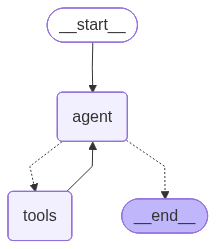

In [ ]:
# ============================================================================
# CREATE THE ReAct AGENT USING LANGGRAPH
# ============================================================================
# create_react_agent() builds a ReAct (Reasoning + Acting) agent that:
# 1. THINKS about what to do (Reasoning)
# 2. Takes an ACTION using tools (Acting)  
# 3. OBSERVES the result
# 4. Repeats until it has the final answer
#
# Parameters:
# - model: The LLM to use for reasoning (GPT-4o)
# - tools: List of tools the agent can use (our SQL tools)
# - state_modifier: System prompt that guides agent behavior
#
# LangGraph's create_react_agent is the modern replacement for deprecated
# LangChain agent implementations - it's more robust and maintainable!
# ============================================================================

from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

# Initialize the LLM for the agent
chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the ReAct agent with our SQL tools and system prompt
text2sql_agent = create_react_agent(
    model=chatgpt,           # The LLM brain
    tools=sql_tools,         # Tools for database interaction
    state_modifier=SYS_PROMPT # System instructions
)

print("✅ Text2SQL ReAct Agent created successfully!")
print("\n📊 Agent Graph Visualization:")
text2sql_agent

## Run and Test Text2SQL Agent

In [ ]:
# ============================================================================
# TEST THE AGENT - BASIC STREAMING OUTPUT
# ============================================================================
# The agent.stream() method yields results as they are generated.
# This allows us to see the agent's thought process in real-time:
# - Each step shows the agent's reasoning and tool calls
# - We can observe the ReAct loop: Think → Act → Observe → Repeat
#
# This example shows the RAW stream output (useful for debugging)
# ============================================================================

from IPython.display import display, Markdown

print("🤖 Agent Query: 'What is the total number of customers?'")
print("=" * 60)
print("\nStreaming agent responses (raw format):\n")

for s in text2sql_agent.stream(
    {"messages": [HumanMessage(content="What is the total number of customers?")]}
):
    display(Markdown(str(s)))
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zm7enNHwZbDzsnYGssjB1chh', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 649, 'total_tokens': 661, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a4d13246c5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a70bc952-0922-43c4-a725-547b685aa541-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_zm7enNHwZbDzsnYGssjB1chh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 649, 'output_tokens': 12, 'total_tokens': 661, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----


{'tools': {'messages': [ToolMessage(content='Branch, Comic, Customer, Employee, Inventory, Publisher, Sale, SaleTransactions', name='sql_db_list_tables', id='5111863a-a209-4465-9dc5-d52bec181352', tool_call_id='call_zm7enNHwZbDzsnYGssjB1chh')]}}

----


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2LOZFy56xsPKWGs7Wob8PHn4', 'function': {'arguments': '{"table_names":"Customer"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 687, 'total_tokens': 703, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a4d13246c5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-95a6604f-7ed4-4ce7-b0f2-e3119ff72797-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Customer'}, 'id': 'call_2LOZFy56xsPKWGs7Wob8PHn4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 687, 'output_tokens': 16, 'total_tokens': 703, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----


{'tools': {'messages': [ToolMessage(content='\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(50) NOT NULL, \n\t"LastName" NVARCHAR(50) NOT NULL, \n\t"Email" NVARCHAR(100), \n\t"Phone" NVARCHAR(20), \n\t"Address" NVARCHAR(100), \n\t"City" NVARCHAR(50), \n\t"State" NVARCHAR(50), \n\t"Country" NVARCHAR(50) NOT NULL, \n\t"PostalCode" NVARCHAR(10), \n\tPRIMARY KEY ("CustomerId")\n)\n\n/*\n3 rows from Customer table:\nCustomerId\tFirstName\tLastName\tEmail\tPhone\tAddress\tCity\tState\tCountry\tPostalCode\n1\tRobert\tTaylor\trobert.taylor@example.com\t555-1111\t123 Main St\tNew York\tNY\tUSA\t10001\n2\tEmily\tDavis\temily.davis@example.com\t555-2222\t456 Oak St\tLos Angeles\tCA\tUSA\t90001\n3\tSarah\tConnor\tsarah.connor@example.com\t555-3333\t789 Pine St\tChicago\tIL\tUSA\t60601\n*/', name='sql_db_schema', id='a85111b8-e747-4123-abcd-29eabe6905c6', tool_call_id='call_2LOZFy56xsPKWGs7Wob8PHn4')]}}

----


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MCyQzyKFE2xMDe8bamm0MuyR', 'function': {'arguments': '{"query":"SELECT COUNT(CustomerId) AS TotalCustomers FROM Customer;"}', 'name': 'sql_db_query'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 960, 'total_tokens': 985, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a4d13246c5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6f20930e-0ead-45df-9748-f9312a0f8fd5-0', tool_calls=[{'name': 'sql_db_query', 'args': {'query': 'SELECT COUNT(CustomerId) AS TotalCustomers FROM Customer;'}, 'id': 'call_MCyQzyKFE2xMDe8bamm0MuyR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 960, 'output_tokens': 25, 'total_tokens': 985, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----


{'tools': {'messages': [ToolMessage(content='[(20,)]', name='sql_db_query', id='6333dc2e-f376-4ea2-99b7-1b64338d840c', tool_call_id='call_MCyQzyKFE2xMDe8bamm0MuyR')]}}

----


{'agent': {'messages': [AIMessage(content='The total number of customers is 20.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 998, 'total_tokens': 1008, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a4d13246c5', 'finish_reason': 'stop', 'logprobs': None}, id='run-30176821-b3a7-4f47-a599-4df80d399aaf-0', usage_metadata={'input_tokens': 998, 'output_tokens': 10, 'total_tokens': 1008, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----


In [ ]:
# ============================================================================
# TEST THE AGENT - PRETTY PRINT STREAMING OUTPUT
# ============================================================================
# Using stream_mode='values' returns the full agent state with all messages.
# The pretty_print() method formats the output nicely for readability.
#
# This shows the complete ReAct reasoning chain:
# 1. Human asks a question
# 2. AI decides which tool to call (e.g., list_tables)
# 3. Tool returns results
# 4. AI reasons and calls next tool (e.g., get_schema)
# 5. ... continues until final answer
# ============================================================================

print("🤖 Agent Query: 'What are the Top 10 most popular comics?'")
print("=" * 70)
print("\nObserve the ReAct loop in action:\n")

for event in text2sql_agent.stream(
    {"messages": [HumanMessage(content="What are the Top 10 most popular comics?")]},
    stream_mode='values'  # Returns full agent state with all messages
):
    event["messages"][-1].pretty_print()

print('\n\n' + '=' * 70)
print('📋 FINAL RESPONSE:')
print('=' * 70)
display(Markdown(event["messages"][-1].content))

================================ Human Message =================================

What are the Top 10 most popular comics?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_it0D6RMiiqBm3AZk3o8Yt87r)
 Call ID: call_it0D6RMiiqBm3AZk3o8Yt87r
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Branch, Comic, Customer, Employee, Inventory, Publisher, Sale, SaleTransactions
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_O2ZJrPyULX9g6R4zokgIzNO2)
 Call ID: call_O2ZJrPyULX9g6R4zokgIzNO2
  Args:
    table_names: Comic, Sale
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Comic" (
	"ComicId" INTEGER NOT NULL, 
	"Title" NVARCHAR(100) NOT NULL, 
	"PublisherId" INTEGER NOT NULL, 
	"Genre" NVARCHAR(50), 
	"Price" NUMERIC(10, 2) NOT NU

Here are the Top 10 most popular comics based on sales:

1. Wolverine: Old Man Logan - 3 copies sold
2. Superman: Red Son - 2 copies sold
3. Ms. Marvel Volume 1 - 2 copies sold
4. Iron Man: Extremis - 2 copies sold
5. Locke & Key Volume 1 - 2 copies sold
6. V for Vendetta - 2 copies sold
7. The Boys Volume 1 - 2 copies sold
8. Lumberjanes Volume 1 - 2 copies sold
9. Punisher: Welcome Back, Frank - 2 copies sold
10. Invincible Volume 1 - 2 copies sold

In [ ]:
# ============================================================================
# CREATE A REUSABLE HELPER FUNCTION FOR QUERYING THE AGENT
# ============================================================================
# This function wraps the agent interaction for cleaner code.
# 
# Parameters:
# - query: The natural language question to ask
# - verbose: If True, shows the full reasoning chain; if False, only final answer
#
# This is a common pattern for production applications where you want
# to hide the internal workings and just show the final result.
# ============================================================================

def call_text2sql_agent(query: str, verbose: bool = False) -> None:
    """
    Query the Text2SQL agent with a natural language question.
    
    Args:
        query: The question to ask (e.g., "What are the top 5 customers?")
        verbose: If True, prints the full reasoning chain; if False, only final answer
    """
    print(f"🤖 Query: '{query}'")
    print("=" * 70)
    
    for event in text2sql_agent.stream(
        {"messages": [HumanMessage(content=query)]},
        stream_mode='values'  # Returns full agent state with all messages
    ):
        if verbose:
            event["messages"][-1].pretty_print()

    print('\n📋 Final Response:\n')
    display(Markdown(event["messages"][-1].content))

print("✅ Helper function 'call_text2sql_agent' defined successfully!")


In [ ]:
# ============================================================================
# NOTE: This query was already demonstrated in the cell above with streaming.
# Commenting out to avoid redundancy. Uncomment to see the helper function in action.
# ============================================================================

# call_text2sql_agent(query="What are the Top 10 most popular comics?",
#                     verbose=True)

================================ Human Message =================================

What are the Top 10 most popular comics?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_9Ph48wbOs47MnUkJlMjjp4rc)
 Call ID: call_9Ph48wbOs47MnUkJlMjjp4rc
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Branch, Comic, Customer, Employee, Inventory, Publisher, Sale, SaleTransactions
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_9uEgGK8IqBVwEFplqhKtmDYb)
 Call ID: call_9uEgGK8IqBVwEFplqhKtmDYb
  Args:
    table_names: Comic, Sale
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Comic" (
	"ComicId" INTEGER NOT NULL, 
	"Title" NVARCHAR(100) NOT NULL, 
	"PublisherId" INTEGER NOT NULL, 
	"Genre" NVARCHAR(50), 
	"Price" NUMERIC(10, 2) NOT NU

Here are the Top 10 most popular comics based on sales:

1. Wolverine: Old Man Logan - 3 copies sold
2. Superman: Red Son - 2 copies sold
3. Ms. Marvel Volume 1 - 2 copies sold
4. Iron Man: Extremis - 2 copies sold
5. Locke & Key Volume 1 - 2 copies sold
6. V for Vendetta - 2 copies sold
7. The Boys Volume 1 - 2 copies sold
8. Lumberjanes Volume 1 - 2 copies sold
9. Punisher: Welcome Back, Frank - 2 copies sold
10. Invincible Volume 1 - 2 copies sold

In [ ]:
# ============================================================================
# EXAMPLE QUERIES - CUSTOMER ANALYTICS
# ============================================================================
# These examples demonstrate the agent's ability to handle various
# business intelligence queries about customers.
# ============================================================================

# Query 1: Customer purchase volume analysis
call_text2sql_agent(
    query="What are the top 5 customers with most comics purchased?",
    verbose=False  # Set to True to see the full reasoning chain
)



Final Response:



The top 5 customers with the most comics purchased are:

1. Tony Stark - 8 comics
2. Sarah Connor - 7 comics
3. Natasha Romanoff - 6 comics
4. Clark Kent - 6 comics
5. Diana Prince - 6 comics

In [ ]:
# ============================================================================
# EXAMPLE QUERY - REVENUE ANALYSIS
# ============================================================================
# This query requires the agent to join multiple tables (Customer, Sale)
# and perform aggregation (SUM) to find high-value customers.
# ============================================================================

# Query 2: Customer revenue analysis  
call_text2sql_agent(
    query="Which are the top 5 customers with most money spent?",
    verbose=False
)



Final Response:



The top 5 customers with the most money spent are:

1. Tony Stark - \$164.94
2. Bruce Wayne - \$139.94
3. Sarah Connor - \$124.96
4. Clark Kent - \$114.96
5. Natasha Romanoff - \$111.96

In [ ]:
# ============================================================================
# EXAMPLE QUERY - EMPLOYEE PERFORMANCE ANALYSIS
# ============================================================================
# This query demonstrates the agent's ability to:
# 1. Understand "salesman" refers to the Employee table
# 2. Join Employee with Sale tables
# 3. Aggregate revenue by employee
# 4. Sort and limit results
# ============================================================================

# Query 3: Sales employee performance
call_text2sql_agent(
    query="Which are the top 3 salesmen with highest revenue?",
    verbose=False
)



Final Response:



The top 3 salesmen with the highest revenue are:

1. John Doe with a total revenue of \$255.89
2. Alice Brown with a total revenue of \$234.94
3. Jane Smith with a total revenue of \$234.88

## 🎯 Summary and Key Takeaways

### What We Built
We created a **Text2SQL ReAct Agentic AI System** that can:
1. Understand natural language questions about our database
2. Automatically explore the database schema
3. Generate and validate SQL queries
4. Execute queries and return human-readable results

### Key Components

| Component | Purpose |
|-----------|---------|
| **SQLDatabase** | LangChain wrapper for database interaction |
| **SQLDatabaseToolkit** | Provides SQL tools (query, schema, list_tables, checker) |
| **System Prompt** | Guides agent behavior and ensures safety |
| **create_react_agent** | LangGraph's ReAct agent implementation |

### The ReAct Loop
```
User Question → List Tables → Get Schema → Generate SQL → Validate → Execute → Format Answer
```

### Best Practices Demonstrated
- ✅ Use raw strings for prompts with special characters
- ✅ Set `temperature=0` for consistent SQL generation
- ✅ Include safety constraints in system prompt (no DML)
- ✅ Always validate queries before execution
- ✅ Use LangGraph's `create_react_agent` (modern approach)

### Try Your Own Queries!
Use the `call_text2sql_agent()` function to ask your own questions about the Comic Store database!


In [ ]:
# ============================================================================
# 🧪 TRY YOUR OWN QUERIES!
# ============================================================================
# Modify the query below to ask your own questions about the database.
# 
# Example questions you can try:
# - "What is the average price of comics by genre?"
# - "Which branch has the most inventory?"
# - "List all comics published before 2000"
# - "Who are the customers from New York?"
# - "What are the total sales for each month?"
# ============================================================================

# Uncomment and modify the query below to test your own questions:

# call_text2sql_agent(
#     query="Your question here...",
#     verbose=True  # Set to True to see the agent's reasoning
# )
